<a href="https://colab.research.google.com/github/ttogle918/AI_practice/blob/main/Ego_Vision_%EC%86%90%EB%8F%99%EC%9E%91_%EC%9D%B8%EC%8B%9D_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C/01_vgg16_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Baseline] VGG16을 이용한 손동작 예측

[[Baseline] VGG16을 이용한 손동작 예측](https://dacon.io/competitions/official/235805/codeshare/3345?page=1&dtype=recent)




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/dataset/dacon/EgoVision/open.zip'

# 패키지 선언

In [3]:
import pandas as pd
import numpy as np
from glob import glob
from io import BytesIO, StringIO
import zipfile

from PIL import Image
import cv2
from tqdm import tqdm

import os
import shutil
import json

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# GPU 환경 설정
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

In [4]:
data_path = 'content'

train_path = data_path + '/train'
test_path = data_path + '/test'

In [5]:
def save_img_data(img_list, zip_file_path) :
  with zipfile.ZipFile(zip_file_path, 'r') as obj:
    for name in img_list :
      obj.extract(name)

def get_data() :
  csv_list, json_list, train_img_list, test_img_list = [], [], [], []
  with zipfile.ZipFile(zip_file_path, 'r') as obj:
    zip_namelist = obj.namelist()    # name 받아오기
    for name in zip_namelist :
      if name.endswith('.csv') :
        csv_list.append(name)
      elif name.endswith('.json') :
        json_list.append(name)
      elif name.endswith('.png') :
        if name.startswith('train/') :
          train_img_list.append(name)
        elif name.startswith('test/') :
          test_img_list.append(name)

  id, actor, actions, action_description, image_id, path = [], [], [], [], [], []
  with zipfile.ZipFile(zip_file_path, 'r') as obj:
    for name in json_list :
        readed = obj.open(name)
        js = json.load(readed)
        length = len(js['annotations'])
        try :
          action = js['action']
          actions.append(action[0])
          action_description.append(action[1])

        except :
          actions.append('')
          action_description.append('')

        id.append(js['id'])
        actor.append(js['actor'])
        path.append(name[:name.rindex('/')])
    answers = pd.DataFrame({'id' : id, 'path':path, 'action':actions, 'action_description':action_description})
  
  with zipfile.ZipFile(zip_file_path, 'r') as obj:
    for name in csv_list :
        readed = obj.read(name)
        print(name)
        if name[-len('hand_gesture_pose.csv'):] == 'hand_gesture_pose.csv' :
          hand_gesture = pd.read_csv(BytesIO(readed))
        else :
          sample_submission = pd.read_csv(BytesIO(readed))
  return train_img_list, test_img_list, answers, hand_gesture, sample_submission

In [6]:
train_img_list, test_img_list, answers, hand_gesture, sample_submission = get_data()

hand_gesture_pose.csv
sample_submission.csv


In [7]:
len(answers.action.unique())

158

In [8]:
hand_gesture.pose_name.unique()

array(['숫자 1', '숫자 2', '숫자 3', '숫자 4', '숫자 5', '숫자 6', '숫자 7', '숫자 8',
       '숫자 9', '숫자 0', '손가락 오므리기', '전화모양', '손 안경', '손가락 접기', '손 토끼', '최고',
       '약속', '검지,중지 교차', '엄지,중지 붙이기', '엄지,소지 붙이기', '파이팅', '총', '동그라미',
       'OK', '빅토리', '부정(엄지손 아래로)', '부정(검지 흔들기)', '손바닥', '약지,소지 가위', '꼬집기',
       '엄지,약지 붙이기', '손하트', '네모', '세모', 'X', '숫자1', '숫자2', '숫자6', '숫자7',
       '숫자8', '숫자0', '숫자3', '숫자4', '숫자5', '숫자9', '경고(주먹 내밀기)', '주먹쥐기',
       '큰하트'], dtype=object)

In [9]:
save_img_data(train_img_list, zip_file_path)

In [10]:
train_answers = answers[answers['path'].apply(lambda x : x[:5]) == 'train']
test_answers = answers[answers['path'].apply(lambda x : x[:4]) == 'test']
len(train_answers), len(test_answers)

(649, 217)

(-0.5, 223.5, 223.5, -0.5)

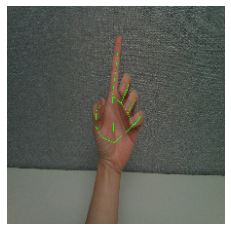

In [11]:
img = image.load_img(train_img_list[0], target_size=(224, 224, 3))
img = image.img_to_array(img)
plt.imshow(img.astype("uint8"))
plt.axis("off")

In [51]:
from keras.preprocessing import image
def gen() :
  arr_train, train_labels = np.array([]), np.array([])
  for name in train_img_list :
    img = image.load_img(name, target_size=(224, 224, 3))
    img = image.img_to_array(img)
    arr_train = np.append(arr_train, img)

    value = train_answers[train_answers['path'].apply(lambda x : x) == name[:name.rindex('/')]].action.values  
    train_labels = np.append(train_labels, value)
  print('len label classes : ', len(set(train_labels)))
  print(set(train_labels))
  print('all labels : ',len(train_labels))
  
  yield arr_train, train_labels

In [ ]:
dataset = tf.data.Dataset.from_generator(gen, output_types=(tf.float32, tf.int16))
# dataset = dataset.batch(32)
dataset

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, y in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.axis("off")

In [45]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
dataset = dataset.map(lambda x, y : (normalization_layer(x), y))

image_batch = next(iter(dataset))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

UnknownError: ignored

# Baseline Modeling

## Preprocessing

# Modeling

In [ ]:
# len(answers.action.unique())-1 : test의 None값도 포함되어있기 때문에 -1
baseModel = VGG16(weights='imagenet', include_top=False)
baseModel.trainable = False

model_in = Input(shape = (224,224,3))
base_model = baseModel(model_in)
head_model = AveragePooling2D(pool_size=(7, 7))(base_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(512, activation="relu")(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation="relu")(head_model)
head_model = Dropout(0.2)(head_model)
model_out = Dense(len(answers.action.unique())-1, activation="softmax")(head_model)

model = Model(inputs=model_in, outputs=model_out)

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20


ValueError: ignored

In [ ]:
predictions = []
for test_image in tqdm(test_images, total = len(test_images)) : 
    prediction = np.mean(model.predict(np.array(test_image)), axis = 0)
    predictions.append(prediction)

sample_submission.iloc[:,1:] = predictions
display(sample_submission.head())
sample_submission.to_csv('./BASELINE.csv', index=False)